# S2HC_ETBF_doc_test_export

**Date:** <br>
10 June 2022 <br>
**Background:** <br>
Issue -  https://github.com/Thomas-Moore-Creative/NCI-ACCESS-S2-ARD/issues/7<br>
**Author(s):**<br>
Thomas Moore<br>

### OOD documentation
https://opus.nci.org.au/display/DAE/Setting+up+a+Dask+Cluster+on+OOD

In [1]:
Author1 = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

In [2]:
import xarray as xr
import numpy as np
import xrft
import xesmf as xe
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import os
import re
import cartopy.crs as ccrs
import proplot as pplt
from rechunker import rechunk
%config Completer.use_jedi = False

## import helper

In [3]:
import importlib.util
spec = importlib.util.spec_from_file_location("helper", "/g/data/v14/tm4888/code/helper-py/helper_tools.py")
helper = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helper)

## OOD cluster

In [4]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="12GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=12)

/g/data/v14/tm4888/miniconda3/envs/pangeo_hpc/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.165:41791,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# load final ETBF S2 025grid collections from zarr

In [6]:
path = '/g/data/xv83/users/tm4888/data/ACCESS-S2/hindcast/'

In [7]:
%%time
ds = xr.open_zarr(path+'accessS2.HC.ocean.masked.AUSWCPregion.ETBFvars.zarr',consolidated=True)

CPU times: user 122 ms, sys: 24.4 ms, total: 146 ms
Wall time: 201 ms


In [8]:
ds

<xarray.Dataset>
Dimensions:              (lat: 361, lon: 721, lead_time: 3, ncorners: 4)
Coordinates:
    forecast_start_date  datetime64[ns] ...
  * lat                  (lat) float64 -70.0 -69.75 -69.5 ... 19.5 19.75 20.0
  * lead_time            (lead_time) datetime64[ns] 2018-03-16T12:00:00 ... 2...
  * lon                  (lon) float64 90.0 90.25 90.5 ... 269.5 269.8 270.0
Dimensions without coordinates: ncorners
Data variables: (12/29)
    areat                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    areau                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    areav                (lat, lon) float32 dask.array<chunksize=(361, 721), meta=np.ndarray>
    eke2000              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    eke300               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    hc300                (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ...                   ...
    temp50               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    temp500              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [9]:
ds = ds.drop_vars(['areat','areau','areav','maskT','maskU','maskV','ocndepu','ocndepv','latt_bounds','latu_bounds','latv_bounds','lont_bounds','lonu_bounds','lonv_bounds'])
ds

<xarray.Dataset>
Dimensions:              (lead_time: 3, lat: 361, lon: 721)
Coordinates:
    forecast_start_date  datetime64[ns] ...
  * lat                  (lat) float64 -70.0 -69.75 -69.5 ... 19.5 19.75 20.0
  * lead_time            (lead_time) datetime64[ns] 2018-03-16T12:00:00 ... 2...
  * lon                  (lon) float64 90.0 90.25 90.5 ... 269.5 269.8 270.0
Data variables: (12/15)
    eke2000              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    eke300               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    hc300                (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    mld1                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ssh_corrected        (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    sss                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ...                   ...
    temp50               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    temp500              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# Tests $\Downarrow$

In [10]:
# Test for zeroes
for varname, da in ds.data_vars.items():
    if (ds[varname] == 0).any():
        raise ValueError(varname + " variable has a zero value <<<")
    else:
        print('No zero values found in '+varname)

No zero values found in eke2000
No zero values found in eke300
No zero values found in hc300
No zero values found in mld1
No zero values found in ssh_corrected
No zero values found in sss
No zero values found in sst
No zero values found in temp100
No zero values found in temp200
No zero values found in temp50
No zero values found in temp500
No zero values found in u100
No zero values found in u100_300
No zero values found in v100
No zero values found in v100_300


In [11]:
# Test for negative values
for varname, da in ds.data_vars.items():
    if (ds[varname] < 0).any():
        print(varname + " variable has negative values <<<")
    else:
        print('No negative values found in '+varname)

No negative values found in eke2000
No negative values found in eke300
hc300 variable has negative values <<<
No negative values found in mld1
ssh_corrected variable has negative values <<<
No negative values found in sss
sst variable has negative values <<<
temp100 variable has negative values <<<
temp200 variable has negative values <<<
temp50 variable has negative values <<<
temp500 variable has negative values <<<
u100 variable has negative values <<<
u100_300 variable has negative values <<<
v100 variable has negative values <<<
v100_300 variable has negative values <<<


# Tests $\Uparrow$

# 

In [13]:
ds

<xarray.Dataset>
Dimensions:              (lead_time: 3, lat: 361, lon: 721)
Coordinates:
    forecast_start_date  datetime64[ns] ...
  * lat                  (lat) float64 -70.0 -69.75 -69.5 ... 19.5 19.75 20.0
  * lead_time            (lead_time) datetime64[ns] 2018-03-16T12:00:00 ... 2...
  * lon                  (lon) float64 90.0 90.25 90.5 ... 269.5 269.8 270.0
Data variables: (12/15)
    eke2000              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    eke300               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    hc300                (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    mld1                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ssh_corrected        (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    sss                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ...                   ...
    temp50               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    temp500              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

# write metadata

In [15]:
#global
ds.attrs = {'regrid_method':'xESMF - bilnear + nearest_s2d extrapolation',
           'product' : 'BOM ACCESS-S2 Hindcast',
           'product URL': 'https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog.search#/metadata/f3311_4920_0252_8073',
           'contact':'thomas.moore@csiro.au'}
#coordinates
ds['lat'].attrs = {'long_name':'latitude','units':'degrees'}
ds['lon'].attrs = {'long_name':'longitude','units':'degrees'}
#ds['time'].attrs = {'long_name':'timestamp','units':'month'}
#variables
#ds['d20'].attrs = {'long_name':'Depth of 20C isotherm','units':'m'}
ds['eke2000'].attrs = {'long_name':'eke depth weighted sum 0-2000m'}
ds['eke300'].attrs = {'long_name':'eke depth weighted sum 0-300m'}
ds['hc300'].attrs = {'long_name':'Heat content 300 m','units':'J/m2'}
ds['mld1'].attrs = {'long_name':'Kara Mixed Layer Depth','units':'m'}
#ds['mld2'].attrs = {'long_name':'Mixed Layer Depth 0.01','units':'m'}
ds['ssh_corrected'].attrs = {'long_name':'Sea Surface Height','units':'m'}
ds['sss'].attrs = {'long_name':'Sea Surface Salinity','units':'PSU'}
ds['sst'].attrs = {'long_name':'Sea Surface Temperature','units':'degC'}
#ds['td'].attrs = {'long_name':'Thermocline Depth','units':'m'}
ds['temp50'].attrs = {'long_name':'Seawater Potential Temperature at 50m','units':'degC'}
ds['temp100'].attrs = {'long_name':'Seawater Potential Temperature at 100m','units':'degC'}
ds['temp200'].attrs = {'long_name':'Seawater Potential Temperature at 200m','units':'degC'}
ds['temp500'].attrs = {'long_name':'Seawater Potential Temperature at 500m','units':'degC'}
ds['u100'].attrs = {'long_name':'x velocity at 100m','units':'m/s'}
ds['v100'].attrs = {'long_name':'y velocity at 100m','units':'m/s'}
ds['u100_300'].attrs = {'long_name':'x velocity depth weighted mean between 100-300m','units':'m/s'}
ds['v100_300'].attrs = {'long_name':'y velocity depth weighted mean between 100-300m','units':'m/s'}
ds

<xarray.Dataset>
Dimensions:              (lead_time: 3, lat: 361, lon: 721)
Coordinates:
    forecast_start_date  datetime64[ns] ...
  * lat                  (lat) float64 -70.0 -69.75 -69.5 ... 19.5 19.75 20.0
  * lead_time            (lead_time) datetime64[ns] 2018-03-16T12:00:00 ... 2...
  * lon                  (lon) float64 90.0 90.25 90.5 ... 269.5 269.8 270.0
Data variables: (12/15)
    eke2000              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    eke300               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    hc300                (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    mld1                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ssh_corrected        (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    sss                  (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    ...                   ...
    temp50               (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    temp500              (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    u100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100                 (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
    v100_300             (lead_time, lat, lon) float32 dask.array<chunksize=(3, 361, 721), meta=np.ndarray>
Attributes:
    regrid_method:  xESMF - bilnear + nearest_s2d extrapolation
    product:        BOM ACCESS-S2 Hindcast
    product URL:    https://geonetwork.nci.org.au/geonetwork/srv/eng/catalog....
    contact:        thomas.moore@csiro.au

# Write out single NC file

In [16]:
%%time
ds.to_netcdf(path+'accessS2.HC.ETBFvars.AUSregion.grid025deg.nc')

CPU times: user 4.36 s, sys: 559 ms, total: 4.92 s
Wall time: 47.2 s


# TEST final NC file
# $\Downarrow$

In [17]:
final_ds = xr.open_dataset(path+'accessS2.HC.ETBFvars.AUSregion.grid025deg.nc')

In [18]:
test_ds = final_ds.mean('lead_time')

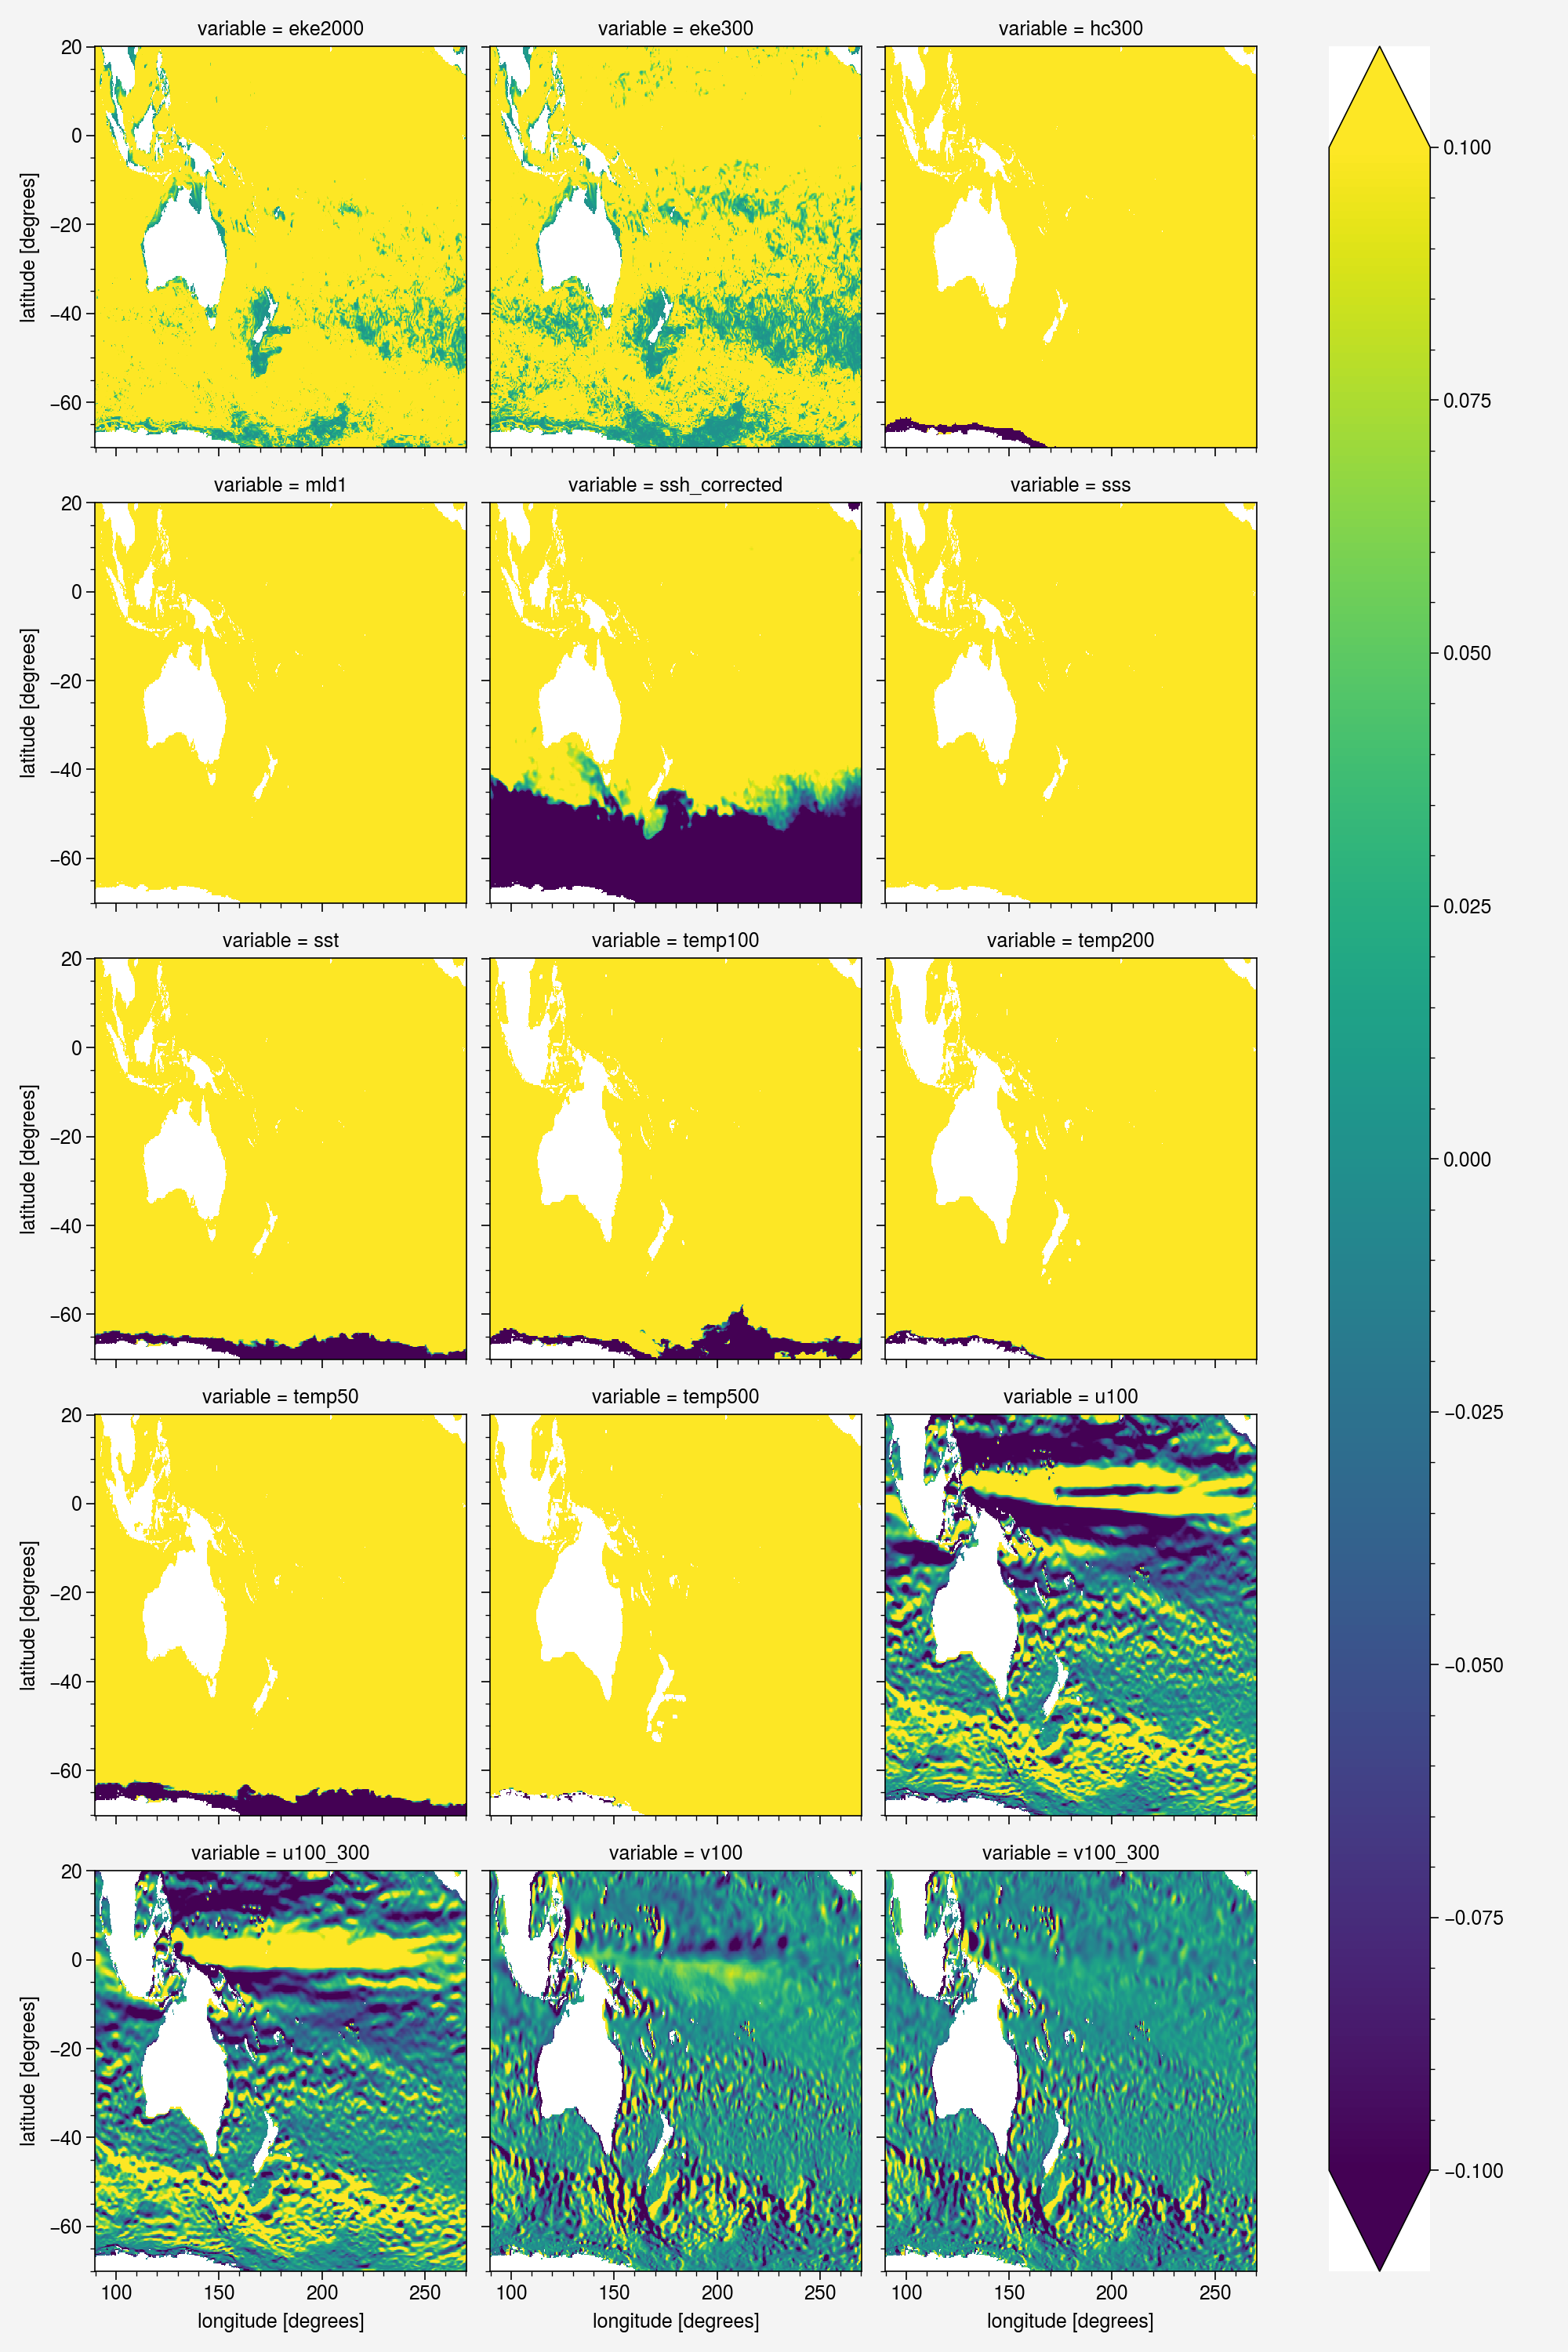

In [19]:
test_ds.to_array().plot(col = 'variable',col_wrap=3,robust=True,vmin = -0.1,vmax= 0.1)

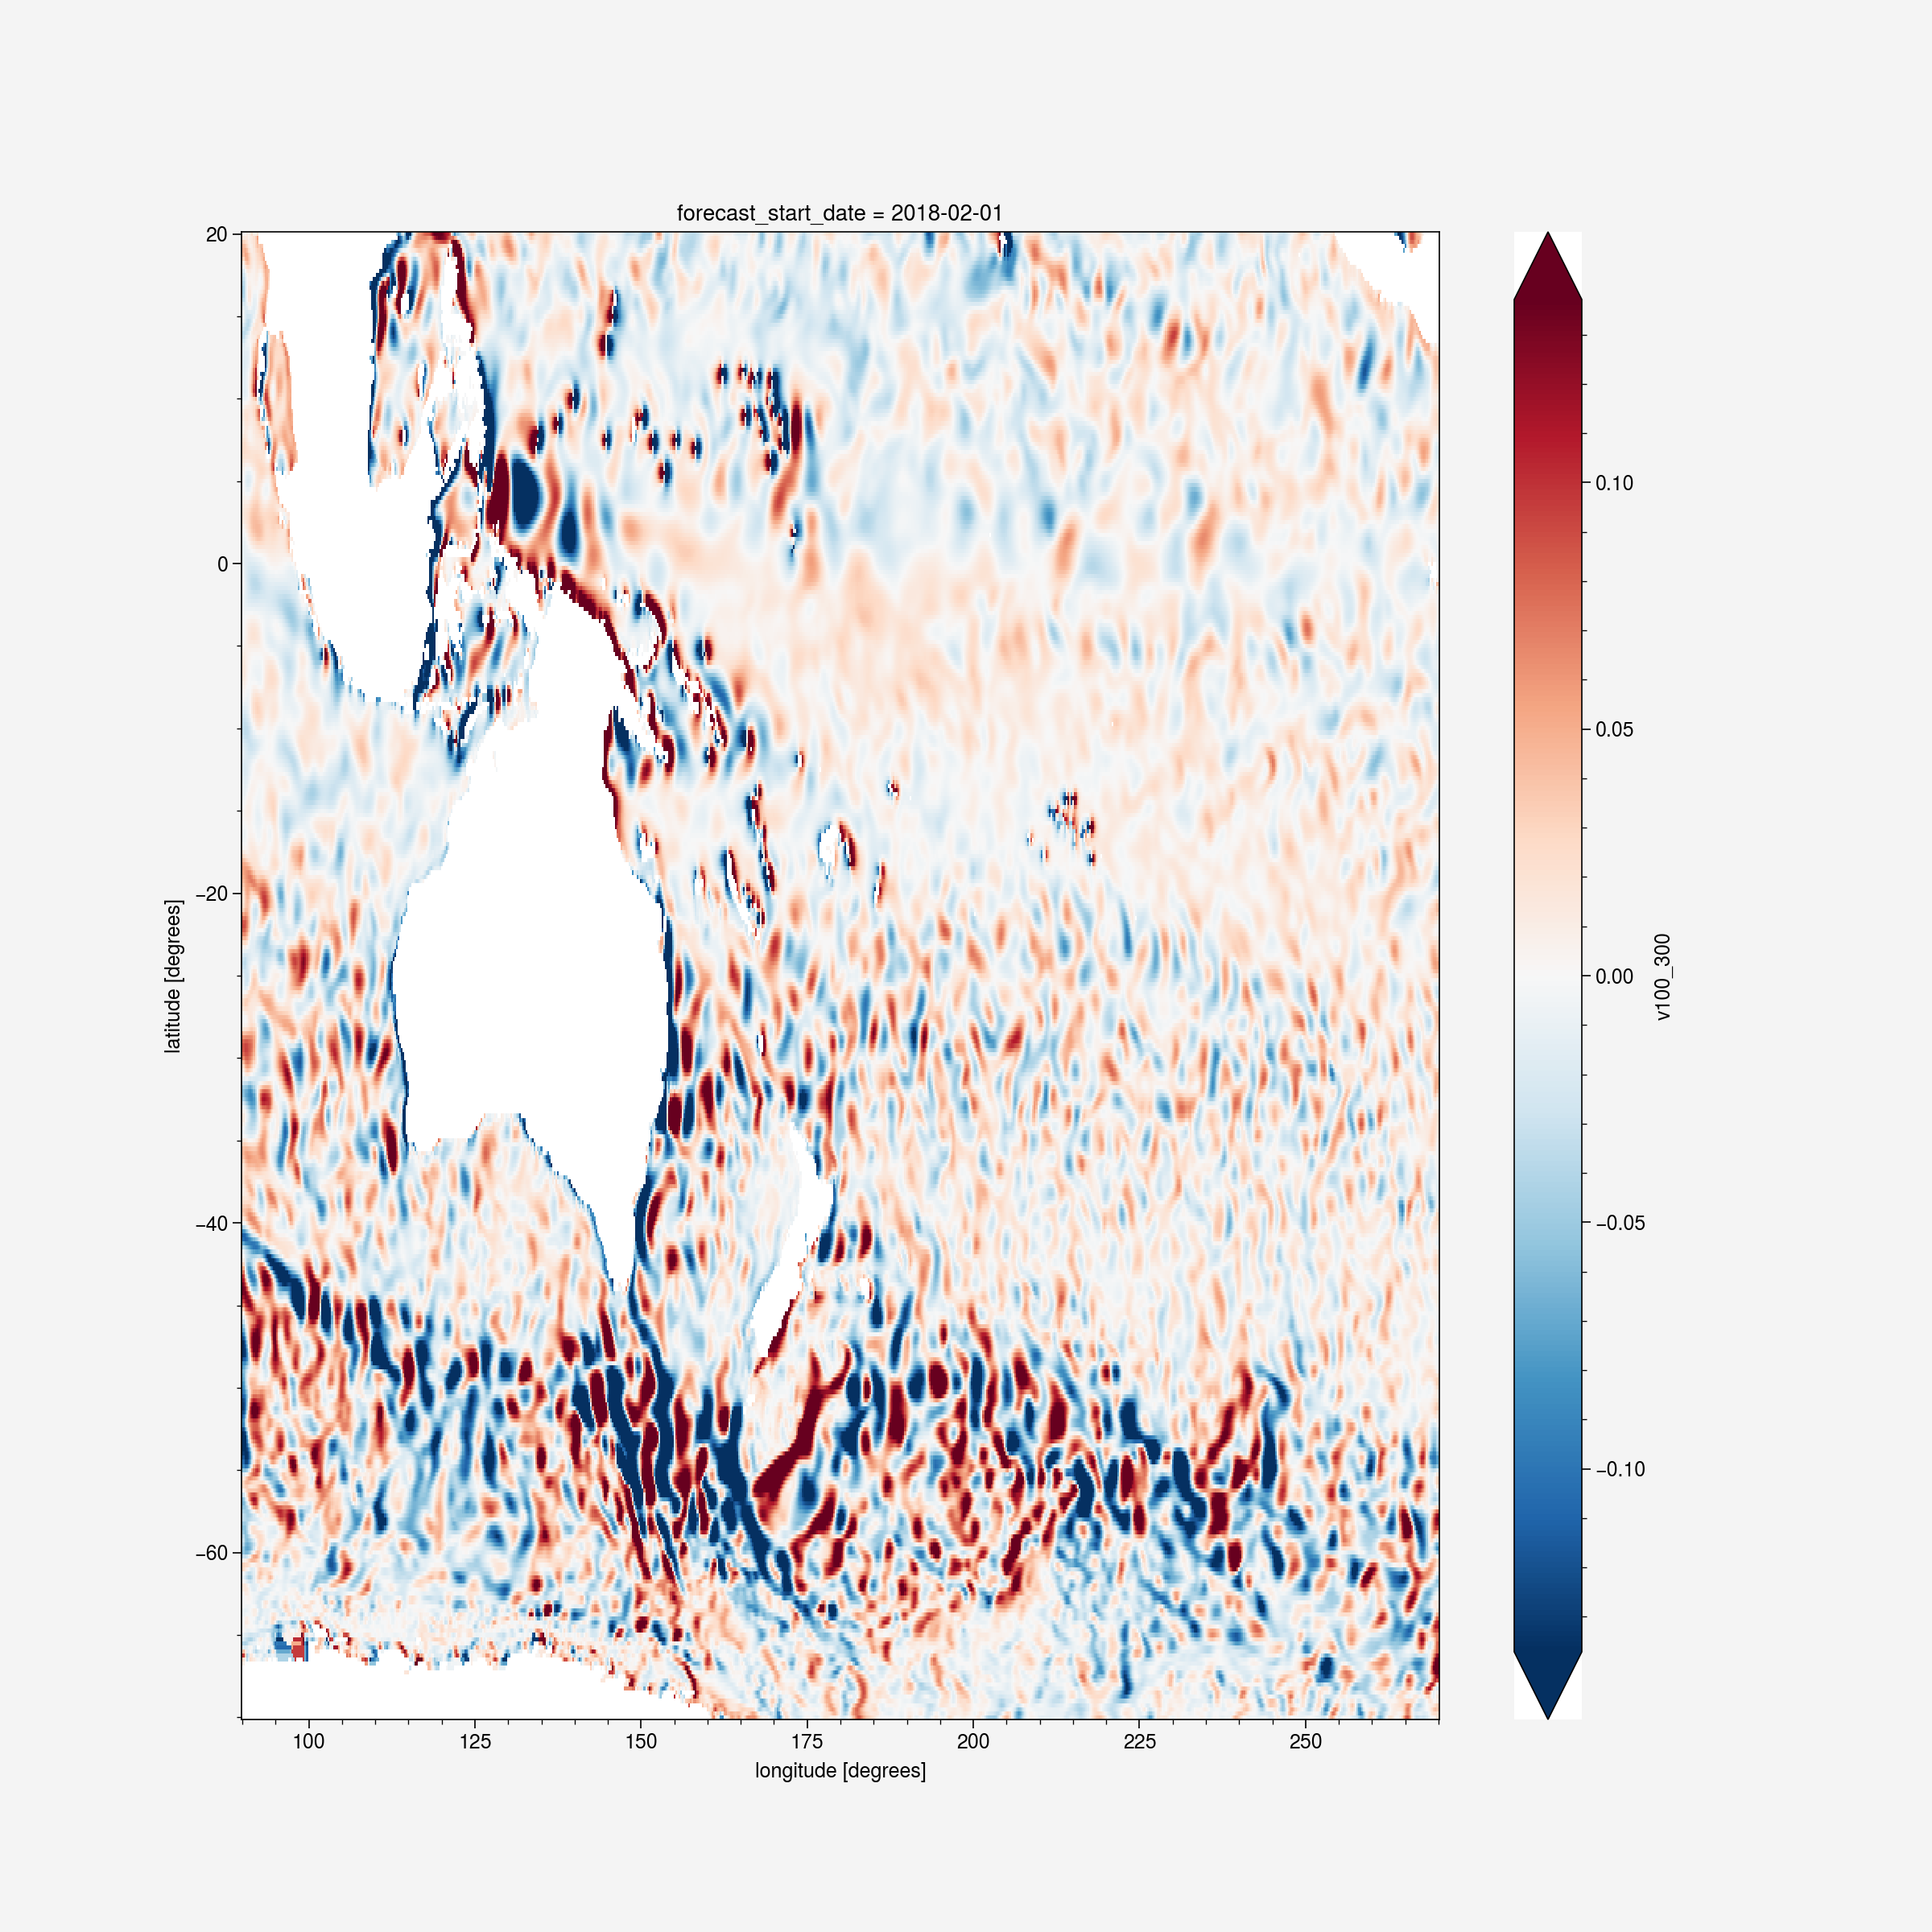

In [23]:
test_ds.v100_300.plot(robust=True,size=12)

# $ The\ End$

# Break glass in case of emergency
# $\Downarrow$

In [ ]:
client.restart()

In [24]:
client.shutdown()

In [ ]:
client.restart()